# 6. Customer / Stakeholder Acceptance (TDSP Step 5)

Tahap ini berfokus pada:
- Memvalidasi apakah model yang dideploy benar-benar menjawab kebutuhan bisnis.
- Menganalisis error untuk memahami kasus di mana model kurang akurat.
- Menyiapkan materi hand-off ke tim operasional / produk.

Notebook ini akan:
1. Memuat dataset bersih dan model yang sudah dideploy.
2. Menghitung metrik kinerja model pada data uji.
3. Melakukan analisis error sederhana (error terbesar dan distribusi error).
4. Menyusun poin-poin acceptance dan hand-off.


In [1]:
# 6.1 Import library, load dataset dan model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Load dataset bersih
data_path_clean = '../Dataset/UsedCarsSA_Clean.csv'
df_clean = pd.read_csv(data_path_clean)

# Pastikan fitur Car_Age ada (jika dipakai di training)
if 'Car_Age' not in df_clean.columns and 'Year' in df_clean.columns:
    df_clean['Car_Age'] = 2025 - df_clean['Year']

# Definisikan target dan fitur
target = 'Price'
X = df_clean.drop(columns=[target])
y = df_clean[target]

# Bagi data menjadi train-test\n
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

# Load model yang sudah disimpan di tahap deployment
model_path = 'used_car_price_model_rf.joblib'
model = joblib.load(model_path)

print('Data dan model berhasil dimuat.')
X_test.head()

Data dan model berhasil dimuat.


,Make,Type,Year,Origin,Color,Options,Engine_Size,Fuel_Type,Gear_Type,Mileage,Region,Car_Age
319,Toyota,Furniture,2014,Saudi,White,Standard,2.7,Gas,Automatic,127000,Jeddah,11
33,Ford,Expedition,2013,Saudi,Black,Standard,5.4,Gas,Automatic,348000,Riyadh,12
8,Toyota,Camry,2017,Gulf Arabic,White,Standard,2.5,Gas,Automatic,107000,Dammam,8
2072,Nissan,Sunny,2019,Saudi,Another Color,Standard,1.5,Gas,Automatic,89000,Al-Medina,6
2080,Hyundai,Tucson,2016,Saudi,Grey,Standard,2.0,Gas,Automatic,72000,Riyadh,9


## 6.2 Evaluasi Ulang Metrik Kinerja

Kita hitung kembali metrik utama untuk keperluan diskusi dengan stakeholder:
- MAE (Mean Absolute Error)
- MAPE (Mean Absolute Percentage Error)
- RMSE (Root Mean Squared Error)
- R squared (R2)


In [2]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    nonzero = y_true != 0
    return np.mean(np.abs((y_true[nonzero] - y_pred[nonzero]) / y_true[nonzero])) * 100

# Prediksi pada data uji
y_pred = model.predict(X_test)

# Hitung metrik
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MAE  : {mae:,.2f}')
print(f'RMSE : {rmse:,.2f}')
print(f'MAPE : {mape:,.2f}%')
print(f'R^2  : {r2:.3f}')

MAE  : 14,317.84
RMSE : 27,463.72
MAPE : 46.43%
R^2  : 0.801


## 6.3 Analisis Error

Analisis error membantu menjawab beberapa pertanyaan penting:
- Pada jenis mobil apa model paling sering salah besar?
- Apakah ada pola tertentu pada region atau segmen tertentu?

Kita buat DataFrame error dan melihat beberapa baris dengan error terbesar.

In [3]:
# Buat DataFrame error
error_df = X_test.copy()
error_df['Actual'] = y_test.values
error_df['Predicted'] = y_pred
error_df['Absolute_Error'] = (error_df['Actual'] - error_df['Predicted']).abs()
error_df['APE'] = error_df['Absolute_Error'] / error_df['Actual'] * 100

error_df.sort_values('Absolute_Error', ascending=False).head(10)

,Make,Type,Year,Origin,Color,Options,Engine_Size,Fuel_Type,Gear_Type,Mileage,Region,Car_Age,Actual,Predicted,Absolute_Error,APE
2705,Mercedes,G,2013,Saudi,Black,Full,6.0,Gas,Automatic,32800,Dammam,12,375000.0,126156.666667,248843.333333,66.358222
5433,Porsche,Cayenne,2019,Saudi,Grey,Full,3.5,Gas,Automatic,36000,Riyadh,6,360000.0,136075.310000,223924.690000,62.201303
2554,Porsche,Panamera,2018,Saudi,Red,Standard,3.5,Gas,Automatic,26000,Dammam,7,330000.0,109021.666667,220978.333333,66.963131
252,Lexus,LX,2018,Saudi,White,Full,1.0,Gas,Automatic,105000,Riyadh,7,355000.0,145451.333333,209548.666667,59.027793
227,Land Rover,Range Rover,2019,Other,Black,Unknown,3.0,Gas,Automatic,1800,Riyadh,6,350000.0,146113.200000,203886.800000,58.253371
4994,Toyota,Land Cruiser,2020,Saudi,White,Standard,4.0,Gas,Automatic,30000,Riyadh,5,2560.0,191116.666667,188556.666667,7365.494792
2418,Lexus,LS,2020,Saudi,Grey,Standard,3.5,Gas,Automatic,2900,Riyadh,5,325000.0,182473.333333,142526.666667,43.854359
733,Land Rover,Range Rover,2019,Saudi,Another Color,Full,3.5,Gas,Automatic,38000,Dammam,6,375000.0,236298.333333,138701.666667,36.987111
2224,Cadillac,Escalade,2020,Saudi,Grey,Full,3.5,Gas,Automatic,5000,Riyadh,5,280000.0,149121.540000,130878.460000,46.742307
3875,Land Rover,Range Rover,2018,Saudi,White,Full,3.8,Gas,Automatic,39000,Jeddah,7,150000.0,275060.000000,125060.000000,83.373333


### Distribusi Error

Kita lihat distribusi Absolute Error dan APE untuk memahami seberapa sering model melakukan error besar.

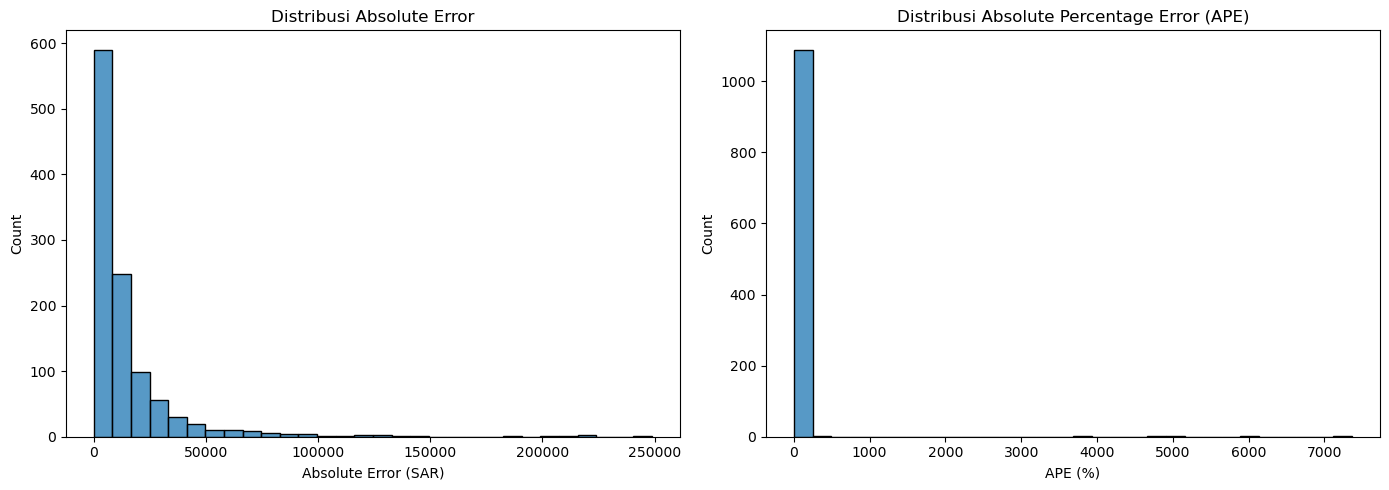

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(error_df['Absolute_Error'], bins=30, ax=axes[0])
axes[0].set_title('Distribusi Absolute Error')
axes[0].set_xlabel('Absolute Error (SAR)')

sns.histplot(error_df['APE'], bins=30, ax=axes[1])
axes[1].set_title('Distribusi Absolute Percentage Error (APE)')
axes[1].set_xlabel('APE (%)')

plt.tight_layout()
plt.show()

### Error per Segmen (Contoh: per Type dan Region)

Kita bisa menghitung rata-rata APE per kategori untuk membantu diskusi dengan stakeholder, misalnya:
- Model apa yang paling stabil prediksinya?
- Region mana yang error-nya relatif tinggi (mungkin data lebih jarang)?


In [5]:
# Rata-rata APE per Type (jika kolom tersebut ada)
if 'Type' in error_df.columns:
    type_error = error_df.groupby('Type')['APE'].mean().sort_values()
    print('Rata-rata APE per Type (5 terbaik):')
    display(type_error.head(5))
    print('\nRata-rata APE per Type (5 terburuk):')
    display(type_error.tail(5))

# Rata-rata APE per Region (jika kolom tersebut ada)
if 'Region' in error_df.columns:
    region_error = error_df.groupby('Region')['APE'].mean().sort_values()
    print('\nRata-rata APE per Region (5 terbaik):')
    display(region_error.head(5))
    print('\nRata-rata APE per Region (5 terburuk):')
    display(region_error.tail(5))

Rata-rata APE per Type (5 terbaik):


Type
C-HR          0.220370
Echo Sport    1.237915
CLS           1.321429
CT-S          1.820833
Acadia        1.941667
Name: APE, dtype: float64


Rata-rata APE per Type (5 terburuk):


Type
Spark               212.162030
EC8                 267.865741
Cadenza             572.206244
Azera              1032.832329
Land Cruiser 70    1643.611368
Name: APE, dtype: float64


Rata-rata APE per Region (5 terbaik):


Region
Wadi Dawasir    10.146259
Al-Baha         14.083451
Al-Medina       15.063483
Yanbu           18.647749
Al-Ahsa         19.048122
Name: APE, dtype: float64


Rata-rata APE per Region (5 terburuk):


Region
Riyadh             42.699729
Tabouk             44.353560
Jeddah             63.369130
Taef              476.313895
Hafar Al-Batin    717.926766
Name: APE, dtype: float64

## 6.4 Poin Diskusi dengan Stakeholder

Beberapa poin yang bisa dibawa ke sesi *acceptance* dengan stakeholder:

1. **Kinerja Model (Overall)**
   - MAE dan MAPE dibandingkan dengan ambang yang disepakati (misalnya MAE ≤ 10% median harga, MAPE ≤ 20%).
   - Nilai R^2 menunjukkan seberapa besar variasi harga yang bisa dijelaskan model.

2. **Kinerja per Segmen**
   - Type atau Region dengan error rata-rata rendah: model cukup stabil.
   - Type atau Region dengan error rata-rata tinggi: bisa jadi kandidat untuk:
     - Penambahan fitur baru,
     - Pengumpulan data tambahan,
     - Atau pengecualian dari cakupan awal model.

3. **Contoh Kasus Error Besar**
   - Tunjukkan beberapa contoh mobil dengan error terbesar.
   - Diskusikan apakah mobil tersebut termasuk kategori langka / luxury / kondisi khusus.

4. **Rekomendasi Penggunaan Model**
   - Model disarankan sebagai **alat bantu rekomendasi harga**, bukan satu-satunya sumber kebenaran.
   - Pengguna (admin / seller) tetap bisa menyesuaikan harga dengan mempertimbangkan faktor-faktor di luar data (kondisi fisik, riwayat servis, dsb.).


## 6.5 Hand-off dan Rencana Lanjutan

Untuk menyelesaikan tahap *Customer / Stakeholder Acceptance*, beberapa artefak yang perlu disiapkan:

1. **Artefak Teknis**
   - File model: `used_car_price_model_rf.joblib`.
   - Script / notebook training (Section 4) dan deployment (Section 5).
   - Notebook ini (Section 6) sebagai dokumentasi analisis error dan hasil evaluasi.

2. **Dokumentasi**
   - Cara menjalankan ulang training ketika ada data baru.
   - Cara melakukan evaluasi berkala (recompute MAE, MAPE, R2).
   - Batasan model (limitations), misalnya:
     - Tidak mempertimbangkan kondisi interior/eksterior secara visual.
     - Kurang akurat untuk jenis mobil sangat langka.

3. **Rencana Iterasi Berikutnya (sesuai prinsip Agile/TDSP)**
   - Jika stakeholder puas dengan performa awal:
     - Lanjut ke pemantauan (*monitoring*) di produksi.
   - Jika ada gap besar antara harapan dan hasil:
     - Kembali ke tahap sebelumnya (Data Understanding atau Modeling) untuk:
       - Menambah fitur baru,
       - Membersihkan atau memperkaya data,
       - Mencoba arsitektur model lain.

Dengan selesainya tahap ini, siklus TDSP satu putaran dianggap lengkap. Model dapat terus ditingkatkan melalui iterasi berikutnya seiring perubahan kebutuhan bisnis dan bertambahnya data baru.
